In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

In [2]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
import scipy

import cx_rate
import trials
import plotter

from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc

import cx_spiking.optimisation.metric as metric
import cx_spiking.optimisation.ng_optimiser as ng_optimiser

In [3]:
######################################
### INPUTS
######################################
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500
T_inbound = 1500
T = T_outbound+T_inbound

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)
headings = np.concatenate((headings, np.zeros((T_inbound, headings.shape[1]))), axis=0)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)
flow = np.concatenate((flow, np.zeros((T_inbound, flow.shape[1]))), axis=0)


######################################
### RATE BASED CX
######################################
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=T_inbound,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz
/Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz exists - not overwriting it


In [4]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [5]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms, name='h_stimulus')
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)', name='P_HEADING')

f_stimulus = TimedArray(flow*Hz, dt=1.*time_step*ms, name='h_stimulus')
P_FLOW = PoissonGroup(N_TN2, rates='f_stimulus(t,i)', name='P_FLOW')

In [6]:
# Neuron groups already optimised
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, TL2_neuron_params, name='TL2')
G_CL1 = nc.generate_neuron_groups(N_CL1, eqs, threshold_eqs, reset_eqs, CL1_neuron_params, name='CL1')
G_TB1 = nc.generate_neuron_groups(N_TB1, eqs, threshold_eqs, reset_eqs, TB1_neuron_params, name='TB1')
G_TN2 = nc.generate_neuron_groups(N_TN2, eqs, threshold_eqs, reset_eqs, TN2_neuron_params, name='TN2')

G_CPU4 = nc.generate_neuron_groups(N_CPU4, eqs, threshold_eqs, reset_eqs, neuron_params, name='CPU4')
G_CPU1A = nc.generate_neuron_groups(N_CPU1A, eqs, threshold_eqs, reset_eqs, neuron_params, name='CPU1A')
G_CPU1B = nc.generate_neuron_groups(N_CPU1B, eqs, threshold_eqs, reset_eqs, neuron_params, name='CPU1B')
G_PONTINE = nc.generate_neuron_groups(N_PONTINE, eqs, threshold_eqs, reset_eqs, neuron_params, name='PONTINE')
G_MOTOR = nc.generate_neuron_groups(N_MOTOR, eqs, threshold_eqs, reset_eqs, neuron_params, name='MOTOR')

In [7]:
SPM_HEADING = SpikeMonitor(P_HEADING, name='SPM_HEADING')
SPM_FLOW = SpikeMonitor(P_FLOW, name='SPM_FLOW')

SPM_TL2 = SpikeMonitor(G_TL2, name='SPM_TL2')
SPM_CL1 = SpikeMonitor(G_CL1, name='SPM_CL1')
SPM_TB1 = SpikeMonitor(G_TB1, name='SPM_TB1')
SPM_TN2 = SpikeMonitor(G_TN2, name='SPM_TN2')
SPM_CPU4 = SpikeMonitor(G_CPU4, name='SPM_CPU4')
SPM_CPU1A = SpikeMonitor(G_CPU1A, name='SPM_CPU1A')
SPM_CPU1B = SpikeMonitor(G_CPU1B, name='SPM_CPU1B')
SPM_PONTINE = SpikeMonitor(G_PONTINE, name='SPM_PONTINE')
SPM_MOTOR = SpikeMonitor(G_MOTOR, name='SPM_MOTOR')

In [8]:
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, params=H_TL2_synapses_params, on_pre=synapses_eqs_ex, name='S_P_HEADING_TL2')
S_TL2_CL1 = nc.connect_synapses(G_TL2, G_CL1, W_TL2_CL1, model=synapses_model, params=TL2_CL1_synapses_params, on_pre=synapses_eqs_ex, name='S_TL2_CL1')
S_CL1_TB1 = nc.connect_synapses(G_CL1, G_TB1, W_CL1_TB1, model=synapses_model, params=CL1_TB1_synapses_params, on_pre=synapses_eqs_ex, name='S_CL1_TB1')
S_TB1_TB1 = nc.connect_synapses(G_TB1, G_TB1, W_TB1_TB1, model=synapses_model, params=TB1_TB1_synapses_params, on_pre=synapses_eqs_in, name='S_TB1_TB1')
S_P_FLOW_TN2 = nc.connect_synapses(P_FLOW, G_TN2, W_FLOW_TN2, model=synapses_model, params=F_TN2_synapses_params, on_pre=synapses_eqs_ex, name='S_P_FLOW_TN2')
S_TB1_CPU4 = nc.connect_synapses(G_TB1, G_CPU4, W_TB1_CPU4, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_in, name='S_TB1_CPU4')
S_TN2_CPU4 = nc.connect_synapses(G_TN2, G_CPU4, W_TN2_CPU4, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_ex, name='S_TN2_CPU4')
S_TB1_CPU1A = nc.connect_synapses(G_TB1, G_CPU1A, W_TB1_CPU1A, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_in, name='S_TB1_CPU1A')
S_CPU4_PONTINE = nc.connect_synapses(G_CPU4, G_PONTINE, W_CPU4_PONTINE, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU4_PONTINE')
S_CPU4_CPU1A = nc.connect_synapses(G_CPU4, G_CPU1A, W_CPU4_CPU1A, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU4_CPU1A')
S_PONTINE_CPU1A = nc.connect_synapses(G_PONTINE, G_CPU1A, W_PONTINE_CPU1A, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_in, name='S_PONTINE_CPU1A')
S_TB1_CPU1B = nc.connect_synapses(G_TB1, G_CPU1B, W_TB1_CPU1B, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_in, name='S_TB1_CPU1B')
S_CPU4_CPU1B = nc.connect_synapses(G_CPU4, G_CPU1B, W_CPU4_CPU1B, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU4_CPU1B')
S_PONTINE_CPU1B = nc.connect_synapses(G_PONTINE, G_CPU1B, W_PONTINE_CPU1B, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_in, name='S_PONTINE_CPU1B')
S_CPU1A_MOTOR = nc.connect_synapses(G_CPU1A, G_MOTOR, W_CPU1A_MOTOR, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU1A_MOTOR')
S_CPU1B_MOTOR = nc.connect_synapses(G_CPU1B, G_MOTOR, W_CPU1B_MOTOR, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU1B_MOTOR')

In [9]:
global CPU4_memory, CPU4_memory_history
CPU4_memory_history = np.zeros((T, N_CPU4))
CPU4_memory = np.zeros(N_CPU4)

def extract_spike_counts(SPM, t, time_step):
    spike_trains = SPM.spike_trains()
    neurons = np.zeros(len(SPM.spike_trains()), dtype=int)
    for idx in range(len(spike_trains)):
        spike_train = spike_trains[idx]
        neurons[idx] = len(spike_train[(spike_train > t-time_step*ms) & (spike_train < t)])
    return neurons

@network_operation(dt=time_step*ms, order=0, name='CPU4_accumulator')
def CPU4_accumulator(t):
    global CPU4_memory, CPU4_memory_history
    
    timestep = int((t/ms + 0.5) / time_step)
    
    if t < time_step*ms:
        return
    spike_trains = SPM_CPU4.spike_trains()
    neurons = extract_spike_counts(SPM_CPU4, t, time_step)    
        
    mem_update = neurons 
    CPU4_memory_history[timestep,:] += mem_update
    CPU4_memory += mem_update
    
    
######################################
### NETWORK OPERATIONS
######################################
global ref_angles, heading_angles, velocities 

ref_angles = np.linspace(-np.pi+np.pi/8, np.pi+np.pi/8, N_TB1, endpoint=False)
max_velocity = 12 

heading_angles = np.zeros(T)
velocities = np.zeros((T, 2))

def circular_weighted_mean(weights, angles):
    x = y = 0.
    for angle, weight in zip(angles, weights):
        x += math.cos(math.radians(angle)) * weight
        y += math.sin(math.radians(angle)) * weight
    mean = math.degrees(math.atan2(y, x))
    return mean


def make_angle(theta):
    return (theta + np.pi) % (2.0 * np.pi) - np.pi


@network_operation(dt=time_step*ms, order=1, name='extract_heading')
def extract_heading(t):
    global ref_angles, heading_angles

    timestep = int((t/ms + 0.5) / time_step)
    
    if t < time_step*ms:
        neurons = [0,0,0,1,1,0,0,0]
        tmp = [angle for i, angle in enumerate(ref_angles) for neuron in range(neurons[i])]
        heading_angles[timestep] = make_angle(scipy.stats.circmean(tmp, low=-np.pi, high=np.pi))
        return
    neurons = extract_spike_counts(SPM_TB1, t, time_step)    
    
    if np.sum(neurons) > 0:
        # trick to get the correct weighted average of where the heading is
        # create a list with all the angles between [-pi,pi] repeated by their count
        # so [0,2,0,0,1,0,0,1] will be [-1.963, -1.963, 0.392, 2.748] and then compute
        # circular mean between [-pi, pi]
        tmp = [angle for i, angle in enumerate(ref_angles) for neuron in range(neurons[i])]
        # -pi/8 because we center the neurons at the center of their pi/4 receptive fields
        heading_angles[timestep] = make_angle(scipy.stats.circmean(tmp, low=-np.pi, high=np.pi) - np.pi/8)
    else:
        heading_angles[timestep] = heading_angles[timestep-1]


@network_operation(dt=time_step*ms, order=2, name='extract_velocity')
def extract_velocity(t):
    global velocities, max_velocity
    
    timestep = int((t/ms + 0.5) / time_step)
    if t < time_step*ms:
        velocities[timestep] = [0,0]
        return
    neurons_responses = extract_spike_counts(SPM_TN2, t, time_step)
    neurons_responses = np.clip(neurons_responses, 0, max_velocity)
    velocities[timestep] = neurons_responses / max_velocity

In [10]:
%%time
net = Network(collect())
net.run((T_outbound)*time_step*ms, report='text')

Starting simulation at t=0. s for a duration of 30. s
1.0371 s (3%) simulated in 10s, estimated 4m 39s remaining.
1.9949 s (6%) simulated in 20s, estimated 4m 41s remaining.
2.9698 s (9%) simulated in 30s, estimated 4m 33s remaining.
4.0084 s (13%) simulated in 40s, estimated 4m 19s remaining.
5.0108 s (16%) simulated in 50s, estimated 4m 9s remaining.
6.2061 s (20%) simulated in 1m 0s, estimated 3m 50s remaining.
7.3919 s (24%) simulated in 1m 10s, estimated 3m 34s remaining.
8.5986 s (28%) simulated in 1m 20s, estimated 3m 19s remaining.
9.716 s (32%) simulated in 1m 30s, estimated 3m 8s remaining.
10.9209 s (36%) simulated in 1m 40s, estimated 2m 55s remaining.
12.1069 s (40%) simulated in 1m 50s, estimated 2m 43s remaining.
13.302 s (44%) simulated in 2m 0s, estimated 2m 31s remaining.
14.313 s (47%) simulated in 2m 10s, estimated 2m 22s remaining.
15.4465 s (51%) simulated in 2m 20s, estimated 2m 12s remaining.
16.5826 s (55%) simulated in 2m 30s, estimated 2m 1s remaining.
17.717

In [11]:
def normalise_CPU4_accumulator(CPU4_memory, vmin=0.15, vmax=0.6):
    L_CPU4 = CPU4_memory[:N_CPU4//2]
    R_CPU4 = CPU4_memory[-N_CPU4//2:]
    L_n = cx_spiking.inputs.normalise_range(L_CPU4, vmin=vmin, vmax=vmax)
    R_n = cx_spiking.inputs.normalise_range(R_CPU4, vmin=vmin, vmax=vmax)
    return np.concatenate((L_n, R_n))

In [12]:
CPU4_memory_normalised = normalise_CPU4_accumulator(CPU4_memory, vmin=0.15, vmax=0.6)

In [20]:
#new_heading = np.array([heading_angles[T_outbound-1]])
#new_headings = cx_spiking.inputs.compute_headings(new_heading, N=N_TL2//2, vmin=5, vmax=100)
#new_headings = np.tile(new_headings, 2) 
#headings[T_outbound,:] = new_headings
#h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms, name='h_stimulus')


In [21]:
#net.run(2*time_step*ms)

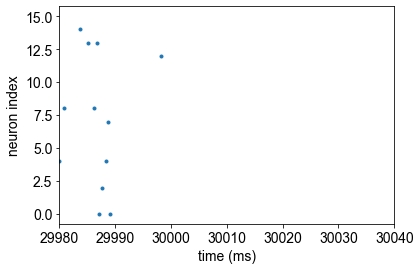

In [13]:
brian_plot(SPM_HEADING)
plt.xlim([29980,30040])
plt.show()

In [14]:
for ts in range(20):
    # prepare inputs
    
    #### motor response
    #motor_responses = extract_spike_counts(SPM_MOTOR, ts*time_step, time_step)
    rotation = 0

    
    #### heading
    # previous heading
    prev_heading = np.array([heading_angles[T_outbound+ts-1]])
    # compute spikes based on old heading and rotation
    new_heading = prev_heading + rotation
    new_headings = cx_spiking.inputs.compute_headings(new_heading, N=N_TL2//2, vmin=5, vmax=100)
    new_headings = np.tile(new_headings, 2) 
    # save new heading
    headings[T_outbound+ts,:] = new_headings
    h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms, name='h_stimulus')


    
    
    
    
    # run newtork for a single timestep
    net.run(time_step*ms)
    
    

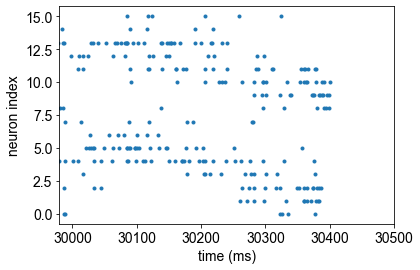

In [15]:
brian_plot(SPM_HEADING)
plt.xlim([29980,30000+20*25])
plt.show()